## Movie Studio Strategy Analysis


## Business Understanding
Overview

This project is designed to aid a company's venture into the movie production industry by launching a new studio. Through comprehensive data analysis, the project will identify current trends and provide actionable insights from box office data. This information will guide the company in determining the types of movies that are most successful in today’s market, thereby supporting strategic content creation and maximizing box office returns

The Problem Statement

The company needs to pinpoint what types of movies are most successful in the current market to propel the new studio's launch. Specifically, we aim to:

1.Identify the genre with the highest profitability(Genres vs ROI,gross,budget)

2.Analyze the relationship between production scale and profitability(Budget vs ROI,gross)

3.Evaluate the impact of release timing on movie financial success(Release Quarter vs ROI)

4.Explore how movie legnth impact profitability(Runtime vs ROI)

# Data Understanding


In [128]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 
import os

%matplotlib inline


In [129]:
# Extracting the zipped imdb file
import zipfile

zip_file_path =  "../zippedData/im.db.zip"
extracted_dir = 'unzipped/imdb_db'
db_file_path = os.path.join(extracted_dir, 'im.db')

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
    print(f"Successfully extracted {len(zip_ref.namelist())} file(s) to {extracted_dir}")

Successfully extracted 1 file(s) to unzipped/imdb_db


In [130]:
# Connect to SQLite database
conn = sqlite3.connect(db_file_path)

# List tables
tables = pd.read_sql("""
                     SELECT name
                     FROM sqlite_master
                     WHERE type='table';
                     """, conn)
print("Tables in the IMDb database:")
print(tables)

Tables in the IMDb database:
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [131]:
## merge required tables then convert it to a dataframe
#Select relevant information from movie_basics table
#JOIN to movie_ratings

imdb = pd.read_sql("""
SELECT *
FROM movie_basics
JOIN movie_ratings
USING(movie_id)
""",conn)
print("shape of imdb:", imdb.shape)
imdb.head()

shape of imdb: (73856, 8)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [132]:
# Summary of imdb data
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [133]:
# Descriptive statistics of imdb
imdb.describe()

,start_year,runtime_minutes,averagerating,numvotes
count,73856.000000,66236.000000,73856.000000,7.385600e+04
mean,2014.276132,94.654040,6.332729,3.523662e+03
std,2.614807,208.574111,1.474978,3.029402e+04
min,2010.000000,3.000000,1.000000,5.000000e+00
25%,2012.000000,81.000000,5.500000,1.400000e+01
50%,2014.000000,91.000000,6.500000,4.900000e+01
75%,2016.000000,104.000000,7.400000,2.820000e+02
max,2019.000000,51420.000000,10.000000,1.841066e+06


In [134]:
# percentage of missing values in imdb
imdb.isnull().mean()*100

movie_id            0.000000
primary_title       0.000000
original_title      0.000000
start_year          0.000000
runtime_minutes    10.317374
genres              1.088605
averagerating       0.000000
numvotes            0.000000
dtype: float64

In [135]:
#  handle rows with missing values 
runtime_median = imdb["runtime_minutes"].median()
imdb["runtime_minutes"].fillna(runtime_median, inplace=True)
imdb.dropna(subset=['genres',], inplace=True)
# confirming no missing values
imdb.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
averagerating      0
numvotes           0
dtype: int64

In [136]:
# Check for duplicates in imdb
imdb.duplicated().value_counts()


False    73052
dtype: int64

In [137]:
# Standardize to ensure easy merging
imdb['title_clean'] = imdb['primary_title'].str.strip().str.lower()
print(f"Unique cleaned titles: {imdb['title_clean'].nunique()} / {len(imdb)} total rows")


Unique cleaned titles: 69197 / 73052 total rows


In [138]:

# Shape of dataset after cleaning
imdb.shape

(73052, 9)

In [139]:
## Load box office Movie data
gross = pd.read_csv("../zippedData/bom.movie_gross.csv.gz")
# Check for shape of dataframe
print("Shape of gross:", gross.shape)
gross.head()


Shape of gross: (3387, 5)


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [140]:
# Summary of gross data
gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [141]:
# changing foreign gross to float datatype
gross["foreign_gross"] = pd.to_numeric(gross["foreign_gross"],errors="coerce")

In [142]:
# Descriptive stats 
gross.describe()

,domestic_gross,foreign_gross,year
count,3.359000e+03,2.032000e+03,3387.000000
mean,2.874585e+07,7.505704e+07,2013.958075
std,6.698250e+07,1.375294e+08,2.478141
min,1.000000e+02,6.000000e+02,2010.000000
25%,1.200000e+05,3.775000e+06,2012.000000
50%,1.400000e+06,1.890000e+07,2014.000000
75%,2.790000e+07,7.505000e+07,2016.000000
max,9.367000e+08,9.605000e+08,2018.000000


In [143]:
# Checking for missing values in gross
gross.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1355
year                 0
dtype: int64

In [144]:
# Create a total gross column by summing domestic and foreign gross
gross['total_gross'] = gross['domestic_gross'] + gross['foreign_gross']

In [145]:

# Check how many movies have complete financial data
print("Movies with complete financial data:", gross['total_gross'].notnull().sum())
print("Movies missing financial data:", gross['total_gross'].isnull().sum())

# For our analysis, we might want to focus on movies with complete financial data
gross = gross.dropna(subset=['total_gross'])
gross = gross[gross['total_gross'] > 0]

Movies with complete financial data: 2004
Movies missing financial data: 1383


In [146]:
# Check for duplicates
gross.duplicated().value_counts()

False    2004
dtype: int64

In [147]:
# Clean title for easy merge
gross['title_clean'] = gross['title'].str.replace(r"\s*\(\d{4}\)", "", regex=True).str.strip().str.lower()


In [148]:
# Check the top 5
gross.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross,title_clean
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09,toy story 3
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09,alice in wonderland
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08,harry potter and the deathly hallows part 1
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08,inception
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08,shrek forever after


In [149]:
## Load numbers dataset with budget
budget = pd.read_csv("../zippedData/tn.movie_budgets.csv.gz")
budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [150]:
# summary of the data
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [180]:
budget["ROI"] = (budget["worldwide_gross"] - budget["production_budget"]) / budget["production_budget"]

In [273]:
# Remove $ and commas before conversion to correct datatype
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    budget[col] = budget[col].replace('[\$,]', '', regex=True).astype(float)

# Extract release quarter and year
budget["release_date"] = pd.to_datetime(budget["release_date"], errors="coerce")
budget["release_year"] = budget["release_date"].dt.year
budget["release_quarter"] = budget["release_date"].dt.quarter
budget['release_month'] = pd.to_datetime(budget['release_date']).dt.month
# Preview
budget.head()


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_quarter,title_clean,ROI,release_month
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2009,4,avatar,5.532577,12
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,2,pirates of the caribbean: on stranger tides,1.546673,5
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,2,dark phoenix,-0.572108,6
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,2,avengers: age of ultron,3.243841,5
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,4,star wars ep. viii: the last jedi,3.153696,12


In [152]:
budget.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
release_year         0
release_quarter      0
dtype: int64

In [153]:
budget.duplicated().value_counts()

False    5782
dtype: int64

In [154]:
# Renaming the title 
budget['title_clean'] = budget['movie'].str.strip().str.lower()

budget.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
 6   release_year       5782 non-null   int64         
 7   release_quarter    5782 non-null   int64         
 8   title_clean        5782 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 406.7+ KB


In [155]:
budget['title_clean'].isnull().value_counts()

False    5782
Name: title_clean, dtype: int64

# Merging

In [156]:
merged_df = pd.merge(imdb, budget, on='title_clean', how='inner')

print("Merged shape:", merged_df.shape)
merged_df.head()


Merged shape: (2927, 17)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_quarter
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,foodfight!,26,2012-12-31,Foodfight!,45000000.0,0.0,73706.0,2012,4
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,on the road,17,2013-03-22,On the Road,25000000.0,720828.0,9313302.0,2013,1
2,tt4339118,On the Road,On the Road,2014,89.0,Drama,6.0,6,on the road,17,2013-03-22,On the Road,25000000.0,720828.0,9313302.0,2013,1
3,tt5647250,On the Road,On the Road,2016,121.0,Drama,5.7,127,on the road,17,2013-03-22,On the Road,25000000.0,720828.0,9313302.0,2013,1
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,the secret life of walter mitty,37,2013-12-25,The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0,2013,4


In [157]:
# Check how many matched
print("IMDb total:", imdb.shape[0])
print("Budget total:", budget.shape[0])
print("Merged total:", merged_df.shape[0])


IMDb total: 73052
Budget total: 5782
Merged total: 2927


In [158]:
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2926
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2927 non-null   object        
 1   primary_title      2927 non-null   object        
 2   original_title     2927 non-null   object        
 3   start_year         2927 non-null   int64         
 4   runtime_minutes    2927 non-null   float64       
 5   genres             2927 non-null   object        
 6   averagerating      2927 non-null   float64       
 7   numvotes           2927 non-null   int64         
 8   title_clean        2927 non-null   object        
 9   id                 2927 non-null   int64         
 10  release_date       2927 non-null   datetime64[ns]
 11  movie              2927 non-null   object        
 12  production_budget  2927 non-null   float64       
 13  domestic_gross     2927 non-null   float64       
 14  worldwid

In [159]:
# Merge all three datasets
full_df = pd.merge(merged_df, gross, on='title_clean', how='left')

# Inspect the merged result
print("Full dataset shape:", full_df.shape)
full_df.head()


Full dataset shape: (2946, 23)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,id,...,domestic_gross_x,worldwide_gross,release_year,release_quarter,title,studio,domestic_gross_y,foreign_gross,year,total_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,foodfight!,26,...,0.0,73706.0,2012,4,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,on the road,17,...,720828.0,9313302.0,2013,1,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0
2,tt4339118,On the Road,On the Road,2014,89.0,Drama,6.0,6,on the road,17,...,720828.0,9313302.0,2013,1,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0
3,tt5647250,On the Road,On the Road,2016,121.0,Drama,5.7,127,on the road,17,...,720828.0,9313302.0,2013,1,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,the secret life of walter mitty,37,...,58236838.0,187861183.0,2013,4,The Secret Life of Walter Mitty,Fox,58200000.0,129900000.0,2013.0,188100000.0


In [160]:
# Drop redundant domestic_gross_x column
movies = full_df.drop(columns=['domestic_gross_x'])

# Rename for clarity
movies.rename(columns={
    'domestic_gross_y': 'domestic_gross',
    'worldwide_gross': 'worldwide_gross_budget',  # if you want to distinguish from BOM
}, inplace=True)

# Check structure again
movies.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2946 entries, 0 to 2945
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   movie_id                2946 non-null   object        
 1   primary_title           2946 non-null   object        
 2   original_title          2946 non-null   object        
 3   start_year              2946 non-null   int64         
 4   runtime_minutes         2946 non-null   float64       
 5   genres                  2946 non-null   object        
 6   averagerating           2946 non-null   float64       
 7   numvotes                2946 non-null   int64         
 8   title_clean             2946 non-null   object        
 9   id                      2946 non-null   int64         
 10  release_date            2946 non-null   datetime64[ns]
 11  movie                   2946 non-null   object        
 12  production_budget       2946 non-null   float64 

In [161]:
# Create a DataFrame showing the count and percentage of missing values per column
missing_data_summary = pd.DataFrame({
    'Total NaNs': full_df.isnull().sum(),
    'Percent Missing': (full_df.isnull().sum() / len(full_df)) * 100
})

# Filter to show only columns that have missing data and sort by the percentage
missing_data_summary = missing_data_summary[missing_data_summary['Total NaNs'] > 0].sort_values(
    by='Percent Missing',
    ascending=False
)

print("--- Missing Data Summary in final_df ---")
print(missing_data_summary)

--- Missing Data Summary in final_df ---
                  Total NaNs  Percent Missing
title                   1443         48.98167
studio                  1443         48.98167
domestic_gross_y        1443         48.98167
foreign_gross           1443         48.98167
year                    1443         48.98167
total_gross             1443         48.98167


## Calculating Profit and ROI

In [162]:
# Add profitability and return ratio
movies['profit'] = movies['worldwide_gross_budget'] - movies['production_budget']
movies["ROI"] = (movies["worldwide_gross_budget"] - movies["production_budget"]) / movies["production_budget"]


# Quick sanity check
movies[['primary_title', 'production_budget', 'worldwide_gross_budget', 'profit', 'ROI']].head()


,primary_title,production_budget,worldwide_gross_budget,profit,ROI
0,Foodfight!,45000000.0,73706.0,-44926294.0,-0.998362
1,On the Road,25000000.0,9313302.0,-15686698.0,-0.627468
2,On the Road,25000000.0,9313302.0,-15686698.0,-0.627468
3,On the Road,25000000.0,9313302.0,-15686698.0,-0.627468
4,The Secret Life of Walter Mitty,91000000.0,187861183.0,96861183.0,1.064409


In [163]:
movies.shape

(2946, 24)

In [164]:
movies.head ()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,id,...,release_year,release_quarter,title,studio,domestic_gross,foreign_gross,year,total_gross,profit,ROI
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,foodfight!,26,...,2012,4,NaN,NaN,NaN,NaN,NaN,NaN,-44926294.0,-0.998362
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,on the road,17,...,2013,1,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0,-15686698.0,-0.627468
2,tt4339118,On the Road,On the Road,2014,89.0,Drama,6.0,6,on the road,17,...,2013,1,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0,-15686698.0,-0.627468
3,tt5647250,On the Road,On the Road,2016,121.0,Drama,5.7,127,on the road,17,...,2013,1,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0,-15686698.0,-0.627468
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,the secret life of walter mitty,37,...,2013,4,The Secret Life of Walter Mitty,Fox,58200000.0,129900000.0,2013.0,188100000.0,96861183.0,1.064409


# Data analysis

In [165]:
# Profitability overview
movies.describe()[['production_budget', 'worldwide_gross_budget', 'profit', 'ROI']]


,production_budget,worldwide_gross_budget,profit,ROI
count,2.946000e+03,2.946000e+03,2.946000e+03,2946.000000
mean,3.446116e+07,1.034303e+08,6.896916e+07,3.079645
std,4.789159e+07,2.054071e+08,1.709965e+08,15.086501
min,1.400000e+03,0.000000e+00,-2.002376e+08,-1.000000
25%,5.000000e+06,2.351108e+06,-2.431767e+06,-0.686961
50%,1.700000e+07,3.018144e+07,9.804550e+06,0.580359
75%,4.000000e+07,1.013250e+08,6.294876e+07,2.591590
max,4.250000e+08,2.776345e+09,2.351345e+09,415.564740


In [210]:
# Profitability by genre
movies['main_genre'] = movies['genres'].str.split(',').str[0]
genre_profit = movies.groupby('main_genre')['worldwide_gross_budget'].mean().sort_values(ascending=False)
genre_profit.head(10)


main_genre
Fantasy      2.961139e+08
Adventure    2.474588e+08
Family       1.971572e+08
Action       1.885127e+08
Animation    1.700755e+08
Sci-Fi       1.459656e+08
Mystery      9.710790e+07
Horror       7.506971e+07
Thriller     6.924054e+07
Biography    6.788001e+07
Name: worldwide_gross_budget, dtype: float64

In [238]:
# Group by genre and calculate averages
genre_group = movies.groupby('main_genre').agg({
    'production_budget': 'mean',
    'worldwide_gross_budget': 'mean',
    'ROI': 'mean'
}).reset_index()

## Visualizations

### Which genre translates the best financially

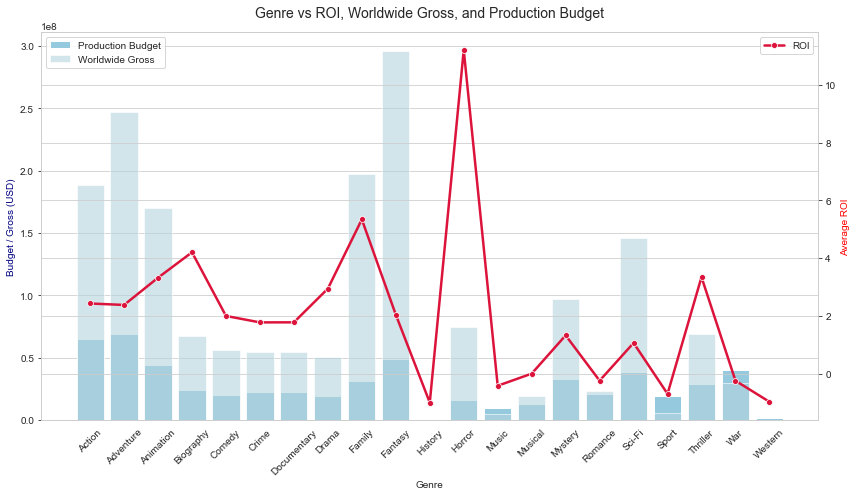

In [243]:

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Create first axis (bars for budgets and gross)
ax1 = plt.gca()

# Plot production budget bars
sns.barplot(
    data=genre_group,
    x='main_genre',
    y='production_budget',
    color='skyblue',
    label='Production Budget',
    ax=ax1
)

# Plot worldwide gross bars on top (lighter shade)
sns.barplot(
    data=genre_group,
    x='main_genre',
    y='worldwide_gross_budget',
    color='lightblue',
    alpha=0.6,
    label='Worldwide Gross',
    ax=ax1
)

# Configure left axis
ax1.set_ylabel('Budget / Gross (USD)', color='navy')
ax1.set_xlabel('Genre')
ax1.tick_params(axis='x', rotation=45)

# Create second axis (ROI line)
ax2 = ax1.twinx()
sns.lineplot(
    data=genre_group,
    x='main_genre',
    y='ROI',
    color='crimson',
    marker='o',
    linewidth=2.5,
    label='ROI',
    ax=ax2
)

ax2.set_ylabel('Average ROI', color='red')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title and layout
plt.title('Genre vs ROI, Worldwide Gross, and Production Budget', fontsize=14, pad=15)
plt.tight_layout()
plt.show()



Interpretation

The chart compares movie genres based on three financial indicators — production budget, worldwide gross, and return on investment (ROI).

Overall, Action, Adventure, and Family movies have the highest worldwide gross, meaning they earn the most money globally. However, they also have very high production budgets, which lowers their profitability.

On the other hand, Horror movies stand out with the highest ROI, even though their budgets are much smaller. This means horror films often bring back far more profit compared to what they cost to make.

Meanwhile, War, Western, and History genres tend to have low or negative ROI, showing that they are expensive to produce but do not perform as well financially.

In summary:

- Horror gives the best profit for its cost.
- Action and Adventure bring high revenue but require huge budgets.
- War and Western  are less efficient investments.



### Relationship betweem production scale and profitability

In [ ]:
# calculating correlation coefficient of budget and ROI
cor = budget['production_budget'].corr(budget['ROI'])
cor

-0.04871481362951171

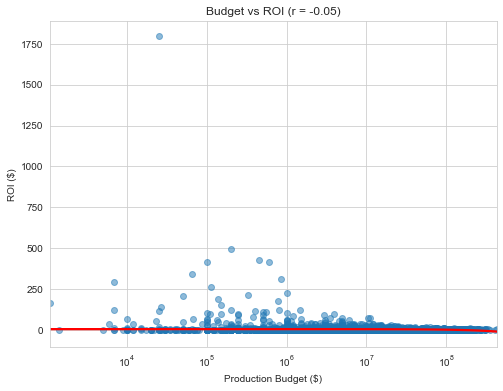

In [250]:
plt.figure(figsize=(8,6))
sns.regplot(data=budget, x="production_budget", y="ROI", scatter_kws={"alpha":0.5},line_kws={"color":"red"})
plt.xscale('log')
plt.title(f"Budget vs ROI (r = {cor:.2f})")
plt.xlabel("Production Budget ($)")
plt.ylabel("ROI ($)")
plt.show()

In [ ]:
# calculating correlation coefficient of budget and gross
corr = budget['production_budget'].corr(budget['worldwide_gross'])
print(corr)

0.7483059765694753


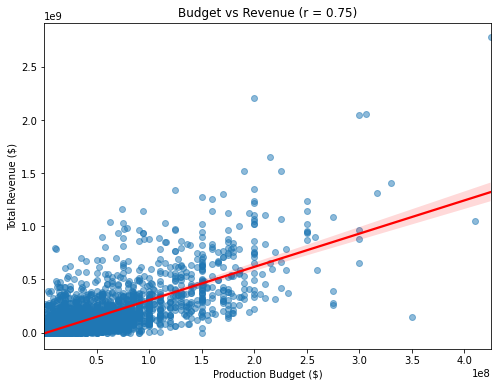

In [189]:
plt.figure(figsize=(8,6))
sns.regplot(data=budget, x="production_budget", y="worldwide_gross", scatter_kws={"alpha":0.5},line_kws={"color":"red"})
plt.title(f"Budget vs Revenue (r = {corr:.2f})")
plt.xlabel("Production Budget ($)")
plt.ylabel("Total Revenue ($)")
plt.show()

- The correlation coefficient,-0.05, shows a negative relation between production budget and ROI. Higher production budgets do not necessarily guarantee higher returns.Big movies are safer but less profitable relative to cost.

- The correlation coefficient, 0.7, shows a strong positive correlation between production budget and total revenue. Higher budget films get higher returns. There is a strong, clear, positive correlation between Production Budget and Worldwide Gross . The data forms a tight, upward-sloping cloud.To achieve the highest absolute revenue, a large budget is necessary. The films grossing over $1 billion are all clustered on the far right, well above the $150M budget mark.

# Effect of runtime on ROI

In [ ]:
import statsmodels.api as sm

# Drop missing runtimes or ROIs
runtime_data = movies.dropna(subset=["runtime_minutes", "ROI"])

# Define variables
X = runtime_data["runtime_minutes"]
y = runtime_data["ROI"]

# Add intercept
X = sm.add_constant(X)

# Fit regression
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.281
Date:                Tue, 11 Nov 2025   Prob (F-statistic):              0.131
Time:                        17:25:26   Log-Likelihood:                -12173.
No. Observations:                2946   AIC:                         2.435e+04
Df Residuals:                    2944   BIC:                         2.436e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.1859      1.422     

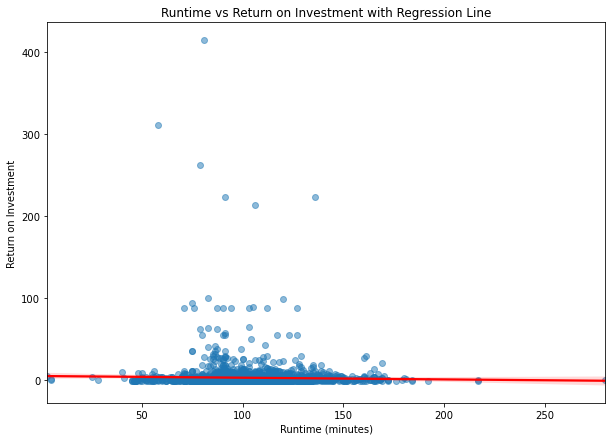

In [174]:
# Visualization
plt.figure(figsize=(10,7))
sns.regplot(x="runtime_minutes", y="ROI", data=movies,
            scatter_kws={"alpha":0.5}, line_kws={"color":"red"})

plt.title("Runtime vs Return on Investment with Regression Line")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Return on Investment")
plt.show()


The visualization displayed above is a scatter plot of movie runtime vs ROI, with the regression line (in red) drawn across the data points. This makes it clear that the trend line is almost flat, confirming that runtime has no meaningful effect on profitability.

-Null Hypothesis (H₀): There is no relationship between movie runtime and ROI.

-Alternative Hypothesis (H₁):There is a relationship between movie runtime and ROI.

-Since the p-value = 0.131 > 0.05, we fail to reject H₀ → meaning runtime does not significantly impact profitability.

The analysis shows that movie length does not significantly impact profitability, whether a film runs shorter or longer has almost no effect on its return on investment (ROI).

# Conclusion
1. Genres like horror use a low budget to produce compared to action movies yet they generate more returns which  shows high budget does not guarantee high returns.

2. If the goal is to make a film that could potentially gross over $1 billion: The studio must enter the high-budget zone.If the goal is the highest average return on investment (ROI): The studio must stick to the low-to-moderate budget zone.

3. The runtime does not influence any return on investment whether long or short.

# Recommendations
Start the new studio by prioritizing high-ROI genres like horror and thriller. Once the studio is financially stable, it can use the profits to take calculated risks on higher-budget movie genres like action to look for high revenue.While large budgets can ensure production quality and consistent gross revenue, profit efficiency (ROI) is often highest among well-executed, lower-budget films.They can produce movie with desired lengths since it does not necessarily affect the returns

